- 特徴量の分布を確認

- 分散の大きさと重要度は異なる（分散が小さいので情報量少なそうに見えるがそれとは別の話）
- 平均値のゆれが大きい特徴量は差分系列にしたほうがよいかも?

In [9]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
%autoreload 2

import os
import sys
import json
import pickle

from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from scipy.stats import kurtosis, skew

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sys.path.append("../")

from src.eda import plot_feature_dist
from src.model import MLModel, LightGBMModel
from src.validation import caluculate_metrics

In [11]:
class cfg:
    dataset_path = "../dataset/v5.0"
    feature_set = "small"

In [12]:
with open(f"{cfg.dataset_path}/features.json", "r") as f:
    feature_metadata = json.load(f)

# print(feature_metadata.keys())
feature_sets = feature_metadata["feature_sets"]
# print(feature_sets.keys())
feature_set = feature_sets[cfg.feature_set]
print(f"feature col length: {len(feature_set)}") 
targets = ["target"]

feature col length: 42


In [16]:
train = pd.read_parquet(
    f"{cfg.dataset_path}/train.parquet",
    columns=["era"] + feature_set + targets
).reset_index(drop=True)
print(train.shape)

(2746270, 44)


In [15]:
eras = train["era"].unique()
print(len(eras))

num_era = len(eras)
cond = train["era"].isin(eras[:num_era])
train = train.loc[cond]
print(train.shape)

574
(2746270, 44)


In [17]:
train.describe()

,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,feature_donnard_groutier_twinkle,feature_elusive_vapoury_accomplice,...,feature_trimeter_soggy_greatest,feature_unanalyzable_excusable_whirlwind,feature_unbreakable_constraining_hegelianism,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute,target
count,2.746270e+06,2.746270e+06,2.746270e+06,2.746270e+06,2.746270e+06,2.746270e+06,2.746270e+06,2.746270e+06,2.746270e+06,2.746270e+06,...,2.746270e+06,2.746270e+06,2.746270e+06,2.746270e+06,2.746270e+06,2.746270e+06,2.746270e+06,2.746270e+06,2.746270e+06,2.746270e+06
mean,1.999918e+00,1.999949e+00,1.999928e+00,1.999924e+00,1.999928e+00,1.999915e+00,1.999915e+00,1.999928e+00,1.999928e+00,1.999915e+00,...,1.999915e+00,1.999915e+00,1.999915e+00,1.999915e+00,1.999928e+00,1.999924e+00,1.999915e+00,1.999915e+00,1.999918e+00,5.000268e-01
std,1.402036e+00,1.096287e+00,1.314663e+00,1.374101e+00,1.320678e+00,1.414359e+00,1.414359e+00,1.320678e+00,1.320678e+00,1.414359e+00,...,1.414359e+00,1.414359e+00,1.414359e+00,1.414359e+00,1.320678e+00,1.374101e+00,1.414359e+00,1.414359e+00,1.402036e+00,2.231753e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.500000e-01
50%,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,5.000000e-01
75%,3.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,...,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,5.000000e-01
max,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,...,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,1.000000e+00


5


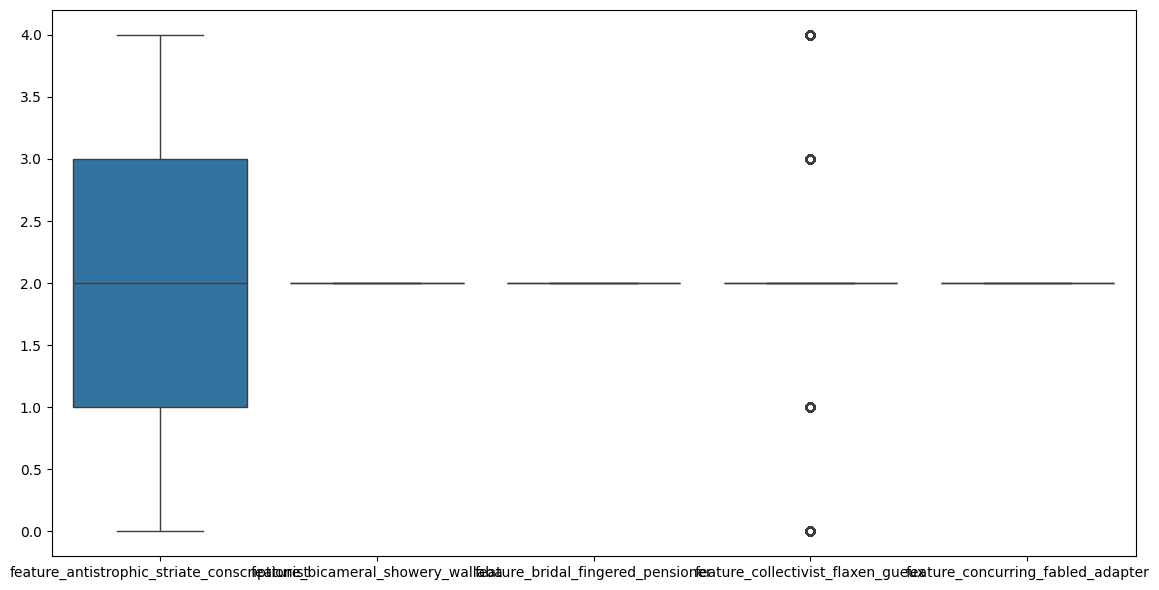

5


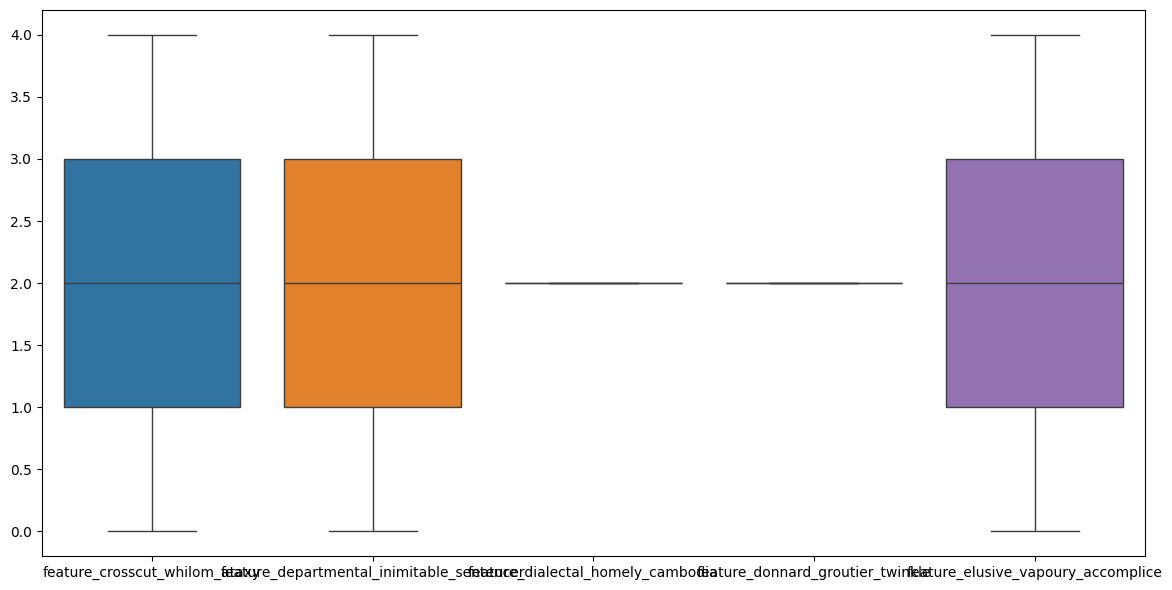

5


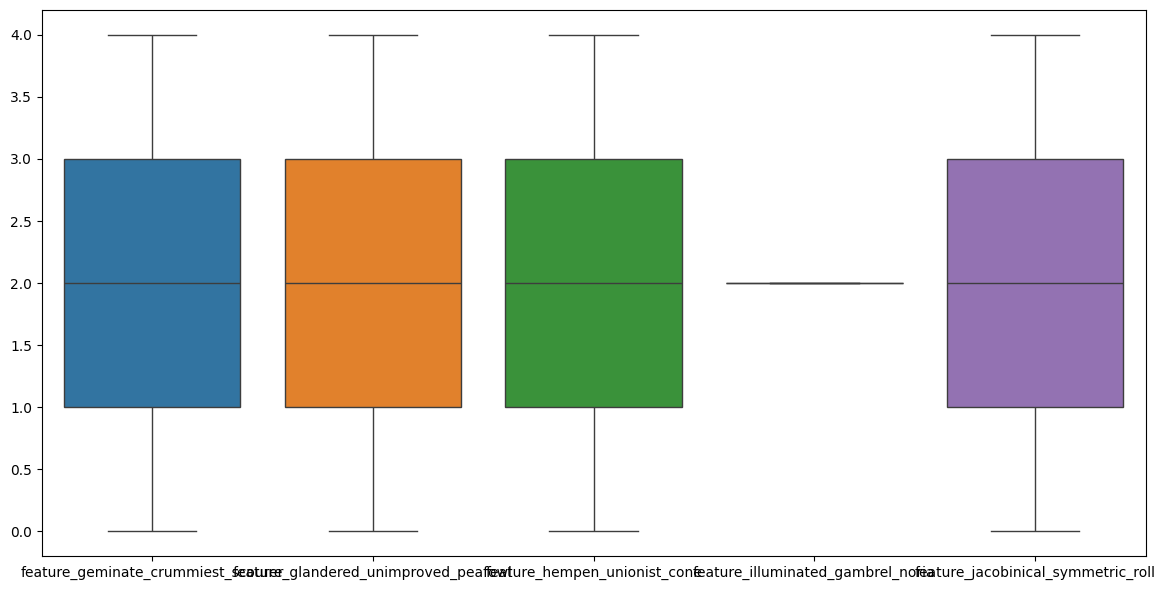

5


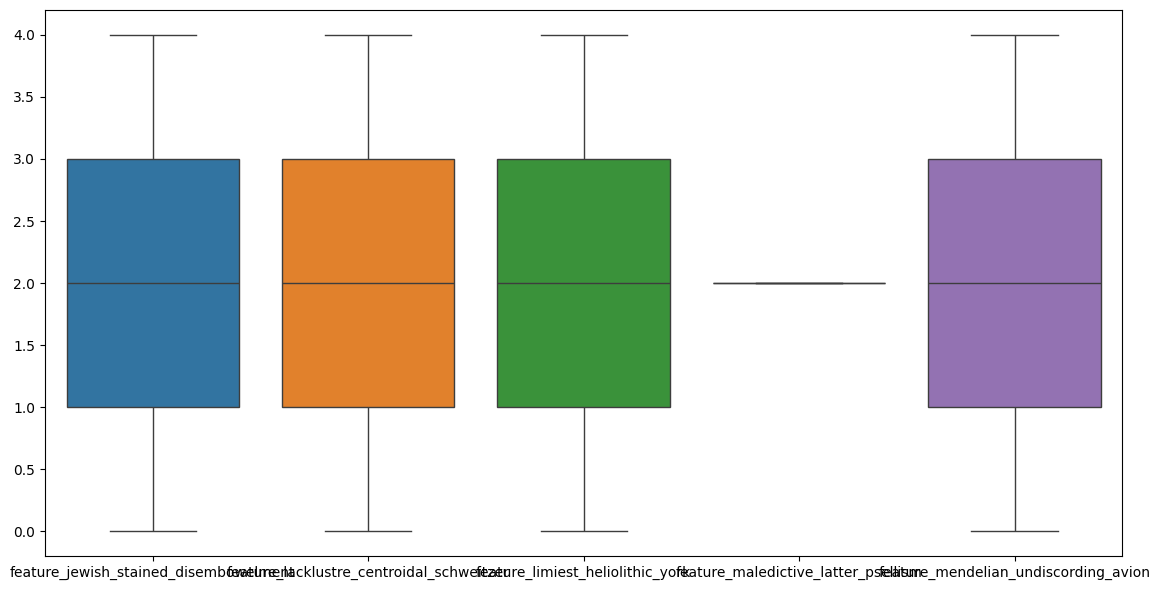

5


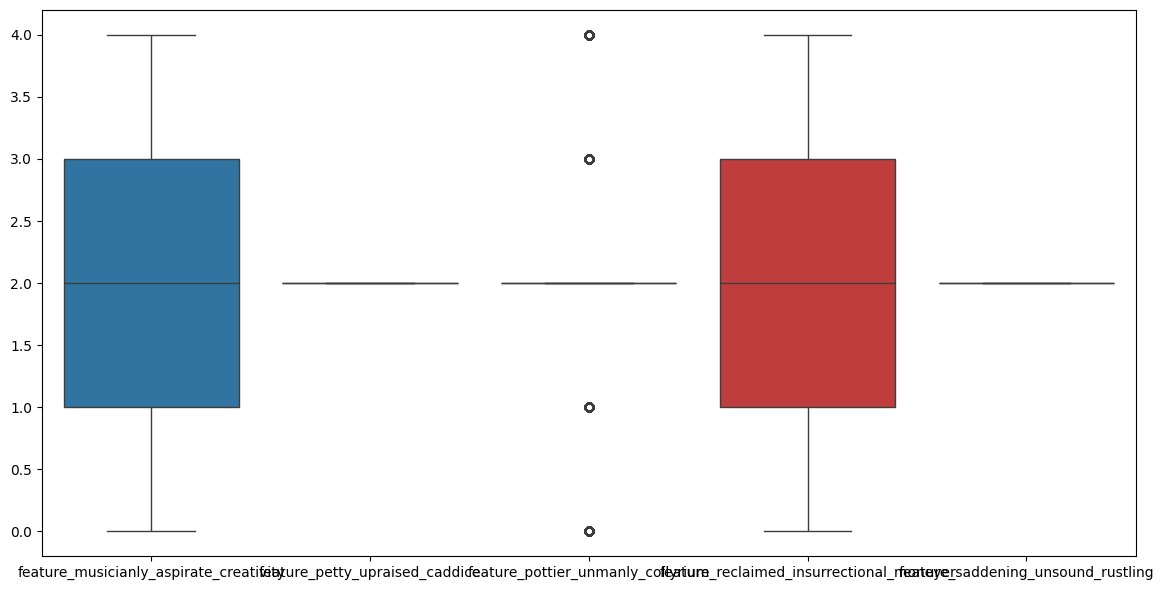

5


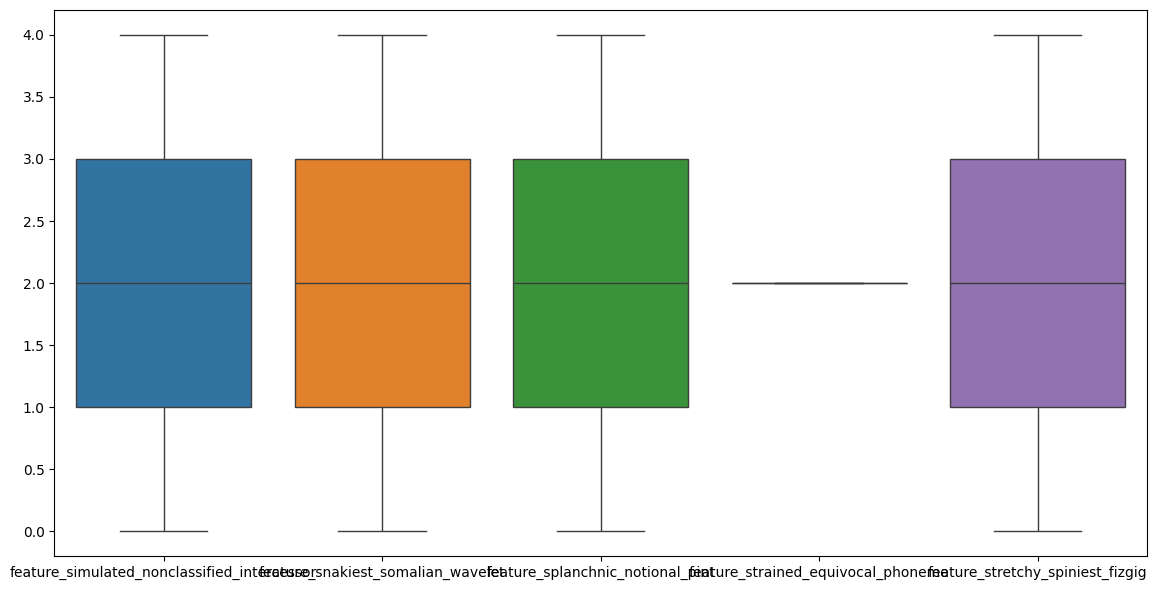

5


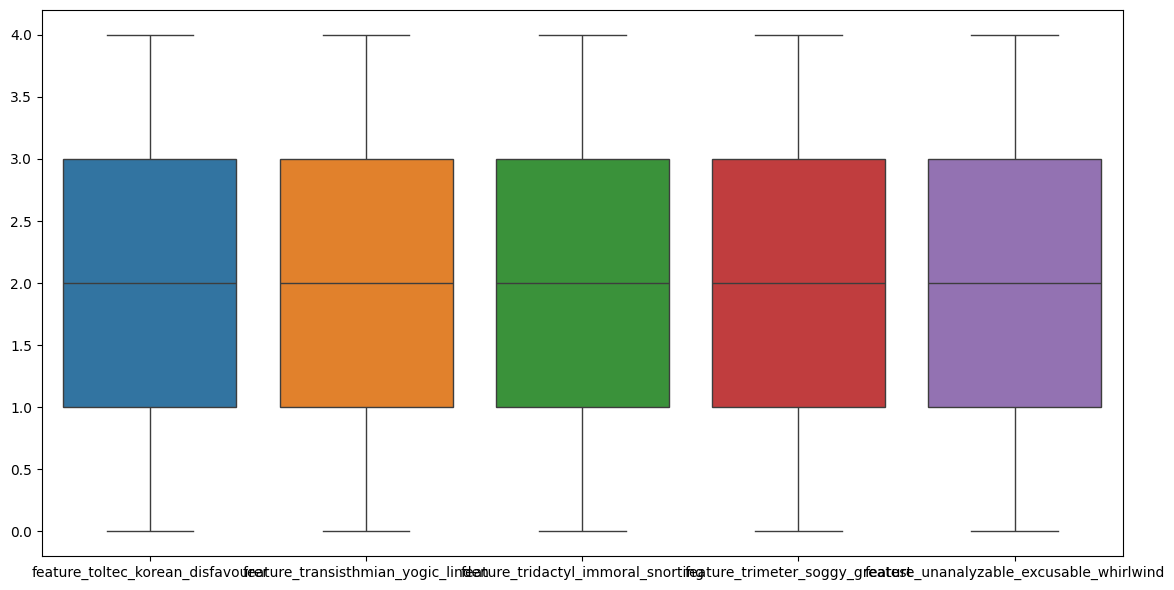

5


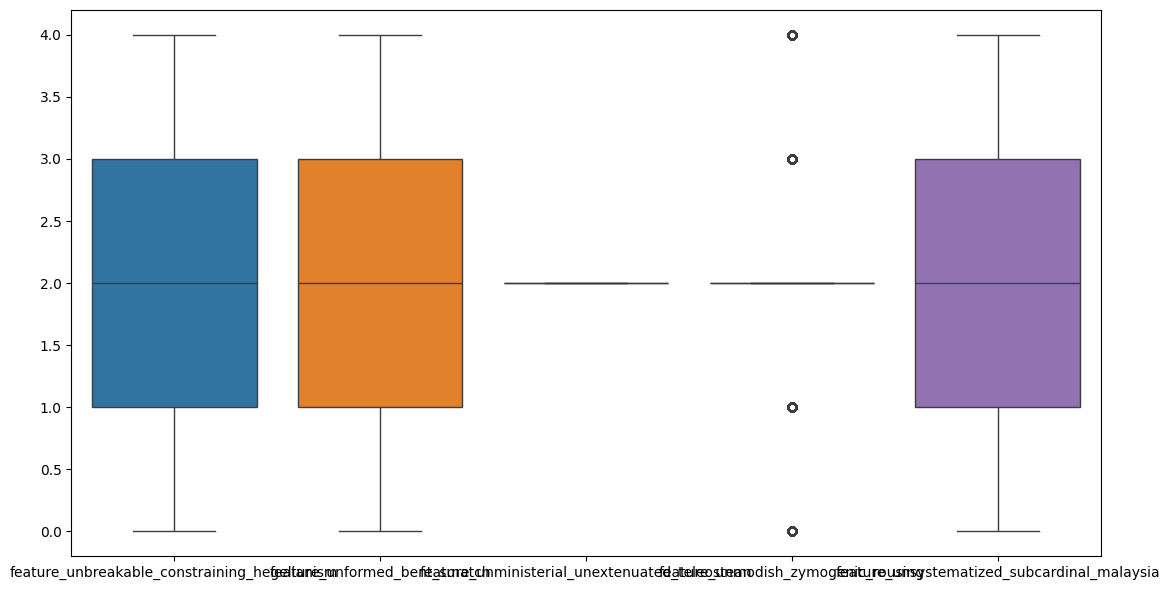

2


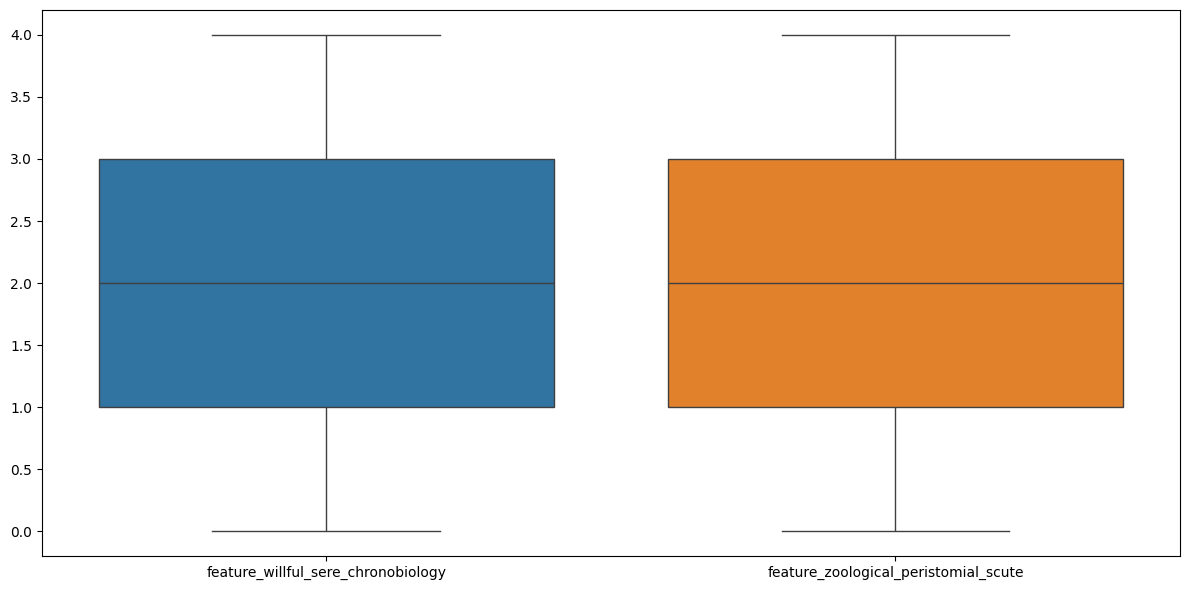

In [7]:
num_features = len(feature_set)
batch_size = 5

for i in range(0,num_features, batch_size):
    selected_features = feature_set[i: i + batch_size]
    print(len(selected_features))
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=train[selected_features], orient="v")
    plt.tight_layout()
    plt.show()
    


In [8]:
train.describe()

,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,feature_donnard_groutier_twinkle,feature_elusive_vapoury_accomplice,...,feature_trimeter_soggy_greatest,feature_unanalyzable_excusable_whirlwind,feature_unbreakable_constraining_hegelianism,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute,target
count,351729.000000,351729.0,351729.0,351729.000000,351729.0,351729.000000,351729.000000,351729.0,351729.0,351729.000000,...,351729.000000,351729.000000,351729.000000,351729.000000,351729.0,351729.000000,351729.000000,351729.000000,351729.000000,351729.000000
mean,1.999926,2.0,2.0,1.999972,2.0,1.999898,1.999898,2.0,2.0,1.999898,...,1.999898,1.999898,1.999898,1.999898,2.0,1.999972,1.999898,1.999898,1.999926,0.500068
std,1.315131,0.0,0.0,1.060212,0.0,1.414409,1.414409,0.0,0.0,1.414409,...,1.414409,1.414409,1.414409,1.414409,0.0,1.060212,1.414409,1.414409,1.315131,0.223064
min,0.000000,2.0,2.0,0.000000,2.0,0.000000,0.000000,2.0,2.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.0,2.0,2.000000,2.0,1.000000,1.000000,2.0,2.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,2.0,2.000000,1.000000,1.000000,1.000000,0.250000
50%,2.000000,2.0,2.0,2.000000,2.0,2.000000,2.000000,2.0,2.0,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.0,2.000000,2.000000,2.000000,2.000000,0.500000
75%,3.000000,2.0,2.0,2.000000,2.0,3.000000,3.000000,2.0,2.0,3.000000,...,3.000000,3.000000,3.000000,3.000000,2.0,2.000000,3.000000,3.000000,3.000000,0.750000
max,4.000000,2.0,2.0,4.000000,2.0,4.000000,4.000000,2.0,2.0,4.000000,...,4.000000,4.000000,4.000000,4.000000,2.0,4.000000,4.000000,4.000000,4.000000,1.000000


In [22]:
per_era_mean = train.groupby("era").mean().reset_index()
display(per_era_mean.head())

,era,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,feature_donnard_groutier_twinkle,...,feature_trimeter_soggy_greatest,feature_unanalyzable_excusable_whirlwind,feature_unbreakable_constraining_hegelianism,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute,target
0,0001,2.0,2.0,2.0,2.0,2.0,1.999136,1.999136,2.0,2.0,...,1.999136,1.999136,1.999136,1.999136,2.0,2.0,1.999136,1.999136,2.0,0.500324
1,0002,2.0,2.0,2.0,2.0,2.0,2.000000,2.000000,2.0,2.0,...,2.000000,2.000000,2.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0,0.500201
2,0003,2.0,2.0,2.0,2.0,2.0,2.000000,2.000000,2.0,2.0,...,2.000000,2.000000,2.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0,0.499901
3,0004,2.0,2.0,2.0,2.0,2.0,2.000000,2.000000,2.0,2.0,...,2.000000,2.000000,2.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0,0.499900
4,0005,2.0,2.0,2.0,2.0,2.0,1.999204,1.999204,2.0,2.0,...,1.999204,1.999204,1.999204,1.999204,2.0,2.0,1.999204,1.999204,2.0,0.500896


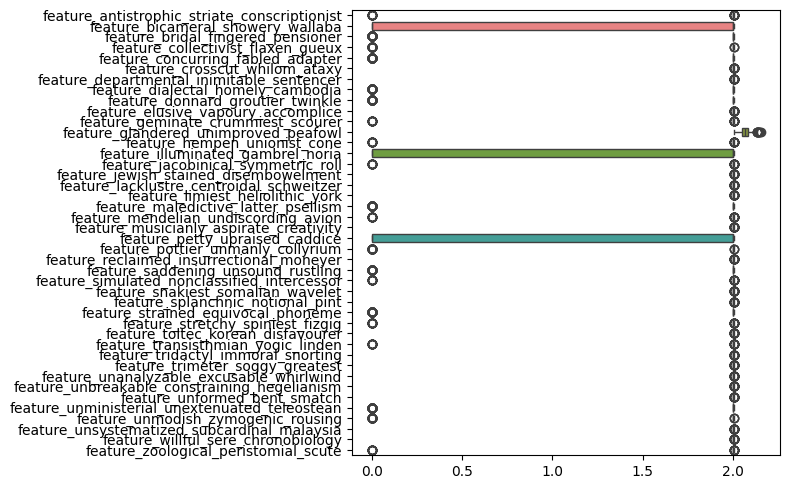

In [29]:
era_variance = train.groupby("era").var().reset_index()


plt.figure(figsize=(8, 5))
sns.boxplot(data=era_variance[feature_set], orient="h")
plt.tight_layout()
plt.show()

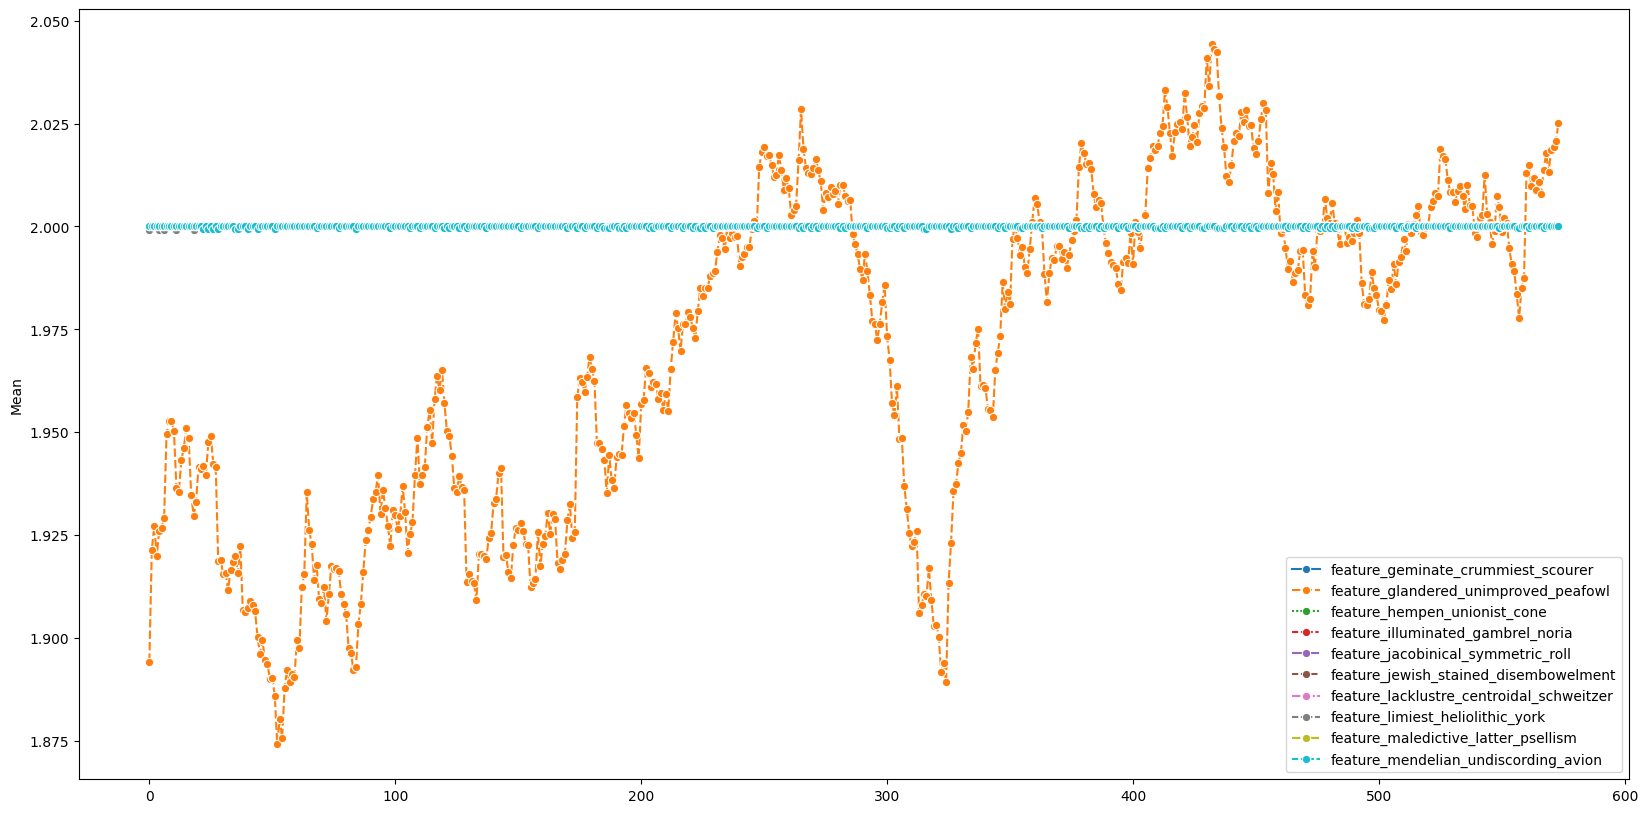

In [89]:
batch_size = 10
i = 1

era_mean = train.groupby("era")[feature_set[batch_size*i:batch_size*(i+1)]].mean().reset_index()
era_var = train.groupby("era")[feature_set[batch_size*i:batch_size*(i+1)]].var().reset_index()

_, ax1 = plt.subplots(figsize=(20, 10))
sns.lineplot(data=era_mean, marker="o", ax=ax1)
ax1.set_ylabel("Mean")
ax1.tick_params(axis="y")

# ax2 = ax1.twinx()
# sns.lineplot(data=era_var, marker="s", ax=ax2)
# ax2.set_ylabel("Variance")
# ax2.tick_params(axis="y")

plt.show()

In [42]:
display(era_mean.head(10))


,era,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,feature_donnard_groutier_twinkle,...,feature_tridactyl_immoral_snorting,feature_trimeter_soggy_greatest,feature_unanalyzable_excusable_whirlwind,feature_unbreakable_constraining_hegelianism,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute
0,0001,2.0,2.0,2.0,2.0,2.0,1.999136,1.999136,2.0,2.0,...,1.999136,1.999136,1.999136,1.999136,1.999136,2.0,2.0,1.999136,1.999136,2.0
1,0002,2.0,2.0,2.0,2.0,2.0,2.000000,2.000000,2.0,2.0,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0
2,0003,2.0,2.0,2.0,2.0,2.0,2.000000,2.000000,2.0,2.0,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0
3,0004,2.0,2.0,2.0,2.0,2.0,2.000000,2.000000,2.0,2.0,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0
4,0005,2.0,2.0,2.0,2.0,2.0,1.999204,1.999204,2.0,2.0,...,1.999204,1.999204,1.999204,1.999204,1.999204,2.0,2.0,1.999204,1.999204,2.0
5,0006,2.0,2.0,2.0,2.0,2.0,2.000000,2.000000,2.0,2.0,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0
6,0007,2.0,2.0,2.0,2.0,2.0,1.999205,1.999205,2.0,2.0,...,1.999205,1.999205,1.999205,1.999205,1.999205,2.0,2.0,1.999205,1.999205,2.0
7,0008,2.0,2.0,2.0,2.0,2.0,2.000000,2.000000,2.0,2.0,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0
8,0009,2.0,2.0,2.0,2.0,2.0,2.000000,2.000000,2.0,2.0,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0
9,0010,2.0,2.0,2.0,2.0,2.0,2.000000,2.000000,2.0,2.0,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0


In [47]:
display(era_mean.head())

era_mean[feature_set].var()

,era,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,feature_donnard_groutier_twinkle,...,feature_tridactyl_immoral_snorting,feature_trimeter_soggy_greatest,feature_unanalyzable_excusable_whirlwind,feature_unbreakable_constraining_hegelianism,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute
0,0001,2.0,2.0,2.0,2.0,2.0,1.999136,1.999136,2.0,2.0,...,1.999136,1.999136,1.999136,1.999136,1.999136,2.0,2.0,1.999136,1.999136,2.0
1,0002,2.0,2.0,2.0,2.0,2.0,2.000000,2.000000,2.0,2.0,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0
2,0003,2.0,2.0,2.0,2.0,2.0,2.000000,2.000000,2.0,2.0,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0
3,0004,2.0,2.0,2.0,2.0,2.0,2.000000,2.000000,2.0,2.0,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0
4,0005,2.0,2.0,2.0,2.0,2.0,1.999204,1.999204,2.0,2.0,...,1.999204,1.999204,1.999204,1.999204,1.999204,2.0,2.0,1.999204,1.999204,2.0


feature_antistrophic_striate_conscriptionist     2.851514e-08
feature_bicameral_showery_wallaba                1.715212e-08
feature_bridal_fingered_pensioner                2.297177e-08
feature_collectivist_flaxen_gueux                2.451722e-08
feature_concurring_fabled_adapter                2.297177e-08
feature_crosscut_whilom_ataxy                    3.293082e-08
feature_departmental_inimitable_sentencer        3.293082e-08
feature_dialectal_homely_cambodia                2.297177e-08
feature_donnard_groutier_twinkle                 2.297177e-08
feature_elusive_vapoury_accomplice               3.293082e-08
feature_geminate_crummiest_scourer               2.851514e-08
feature_glandered_unimproved_peafowl             1.627634e-03
feature_hempen_unionist_cone                     2.851514e-08
feature_illuminated_gambrel_noria                1.827576e-08
feature_jacobinical_symmetric_roll               2.851514e-08
feature_jewish_stained_disembowelment            3.293082e-08
feature_

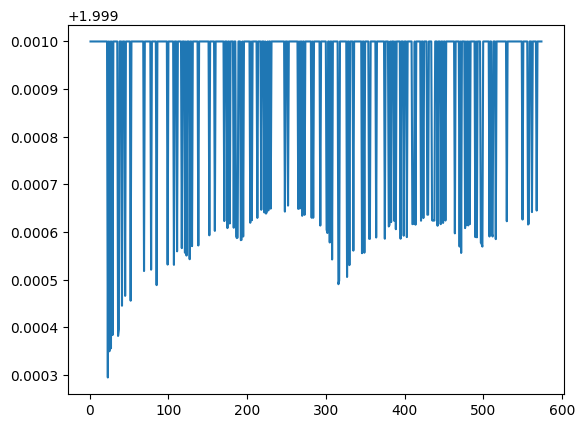

In [87]:
plt.plot(era_mean["era"].astype(int), era_mean["feature_jacobinical_symmetric_roll"])
plt.show()

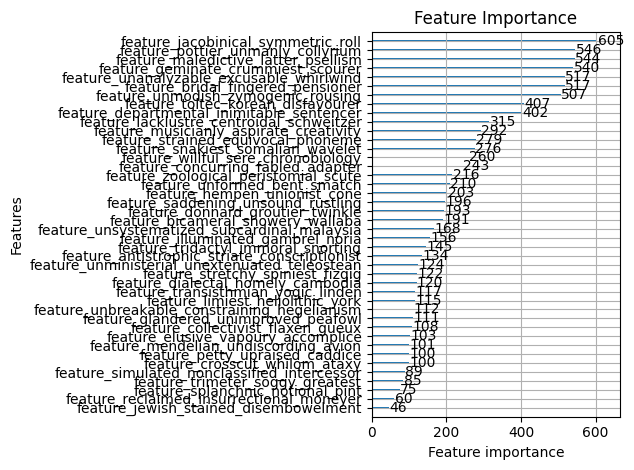

In [85]:
model_path = "exp007"
model = LightGBMModel({})
model.load_model(os.path.join(model_path, "model_0.pkl"))

model.visualize_feature_importance()

In [86]:

importance = pd.DataFrame({
    "name": model.model.feature_name(),
    "importance": model.model.feature_importance()
})

importance.sort_values("importance", ascending=False).head(30)

,name,importance
14,feature_jacobinical_symmetric_roll,605
22,feature_pottier_unmanly_collyrium,546
18,feature_maledictive_latter_psellism,544
10,feature_geminate_crummiest_scourer,540
2,feature_bridal_fingered_pensioner,517
34,feature_unanalyzable_excusable_whirlwind,517
38,feature_unmodish_zymogenic_rousing,507
30,feature_toltec_korean_disfavourer,407
6,feature_departmental_inimitable_sentencer,402
16,feature_lacklustre_centroidal_schweitzer,315
